# Assignment 1
### Benjamin Tollison
This is my 3rd re-write of the code and it went from not working at all to running for 7 hours to now being able to kill the python kernel in under 30mins on my computer. I kept the computation in the global scope to prevent all the calls/checks that my older versions were doing and slowing down time. I know this makes my code not as 'pretty', but it runs significantly faster.

The way that I set up the mesh is that the number of nodes will always be a perfect square. All the nodes are placed equal distance from each other producing the following mesh. You can tweak the mesh density coefficient ($\rho_{mesh}$) value to increase the number of nodes. It works best if you $\rho_{mesh} < 31$ and odd. I got my first 'python 3.11.2 kernel is dead' error by pushing the density to 31.

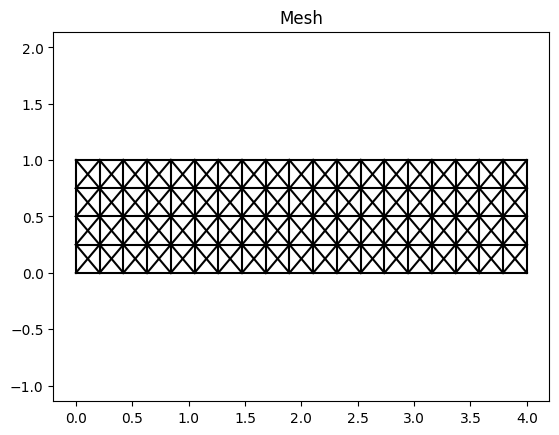

In [17]:
### Benjamin Tollison ### 
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def PlotSturcture(N,C,color:str):
    m,_ = C.shape
    for i in range(m):
        ii = np.nonzero(C[i])
        plt.plot(N[0,ii][0],N[1,ii][0],color)
        plt.axis('equal')

mesh_density_coefficient = 5 # Change this one variable for a finer mesh
length = 4
height = 1
delta = 1/mesh_density_coefficient
x_step_number,y_step_number = int(length/delta), int(height/delta)
x_cooridinates,y_cooridinates = np.linspace(0,length,x_step_number), np.linspace(0,height,y_step_number)
X,Y = np.meshgrid(x_cooridinates,y_cooridinates)
N = np.vstack((X.ravel(),Y.ravel()))
number_of_nodes = x_step_number*y_step_number
number_of_members = int(6+10*(number_of_nodes**0.5-2)+4*(number_of_nodes**0.5-2)**2)
C = np.zeros((number_of_members,number_of_nodes))
duplicate_check_set = set()
current_duplicate_check_len = len(duplicate_check_set)
member_index_counter = 0
member_lengths = np.zeros(number_of_members)
for node in range(number_of_nodes-1):
  for other_node in range(1,number_of_nodes):
    if node != other_node:
       node_x1,node_y1 = N[0][node],N[1][node]       
       other_node_x1,other_node_y1 = N[0][other_node],N[1][other_node]
       distance_between_nodes = ((node_x1-other_node_x1)**2+(node_y1-other_node_y1)**2)**0.5
       if distance_between_nodes < delta*2 and member_index_counter < number_of_members:
        connection_check_node_indices = [node,other_node]
        connection_to_check = tuple(1 if i in connection_check_node_indices else 0 for i in range(number_of_nodes))
        duplicate_check_set.add(connection_to_check)
        if len(duplicate_check_set) != current_duplicate_check_len:
          C[member_index_counter][node], C[member_index_counter][other_node] = 1,-1
          member_lengths[member_index_counter] = distance_between_nodes
          member_index_counter += 1
          current_duplicate_check_len = len(duplicate_check_set)
PlotSturcture(N,C,'k')
plt.title('Mesh')
plt.show()

### Now to solve for the 1 norm solution
After solving the 1 norm solution then you apply all the indices that are non-zero and non-negative to then be the only remaining members.

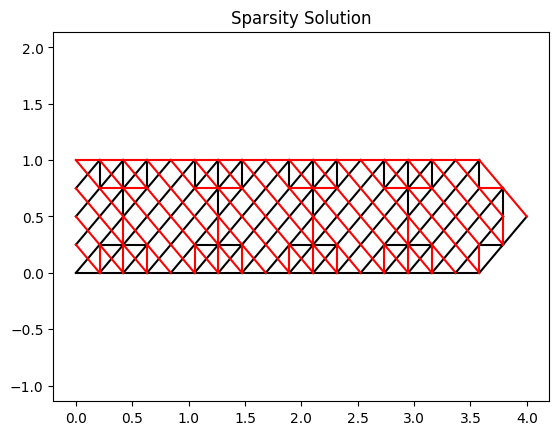

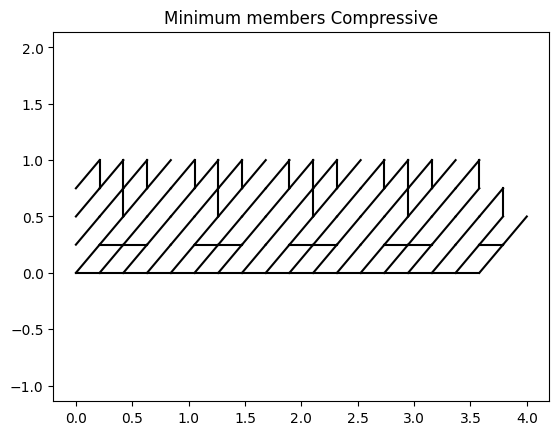

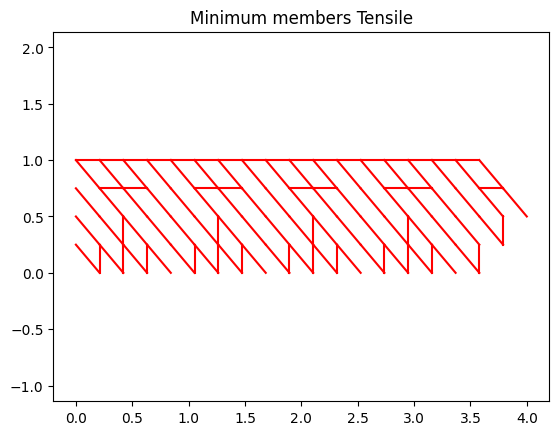

In [18]:
C_B, C_S = C, C
sigma_B = cp.Variable(number_of_members)
sigma_S = cp.Variable(number_of_members)
free_nodes = [i for i in np.where(N[0] != 0.0)]
F_ext = np.zeros((2, number_of_nodes))
R = cp.Variable((2,number_of_nodes))
far_right_nodes = [i for i in map(list,np.where(N[0] == length))]
node_where_F_is_applied = np.argmin(np.abs(N[1][far_right_nodes] - height/2))
P = -1*10**3
F_ext[1][far_right_nodes[0][node_where_F_is_applied]] += P
compressive_yield_stress = 500*10**6 #Pa
tensile_yield_stress = 800*10**6 #Pa
Cost = cp.norm(sigma_B,1) + cp.norm(sigma_S,1)
Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
              R[:,free_nodes[0]] == 0,
              sigma_B >= 0,
              sigma_S >= 0]
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.ECOS)
sigma_bar_member_indices = np.where(sigma_B.value >= 1*10**-3)[0]
sigma_cable_member_indices = np.where(sigma_S.value >= 1*10**-3)[0]
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[sigma_bar_member_indices]
C_S_final = C_S[sigma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Sparsity Solution')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Minimum members Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum members Tensile')
plt.show()

### Finding the minimal mass solution

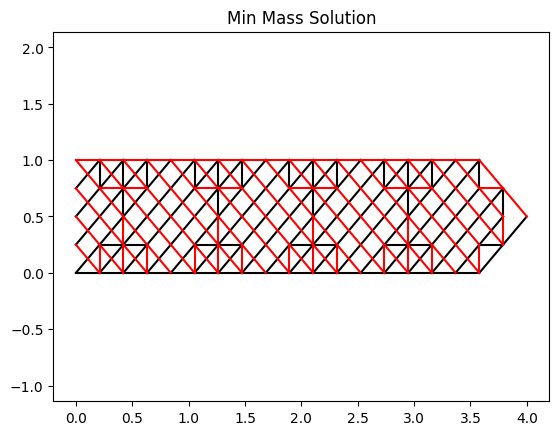

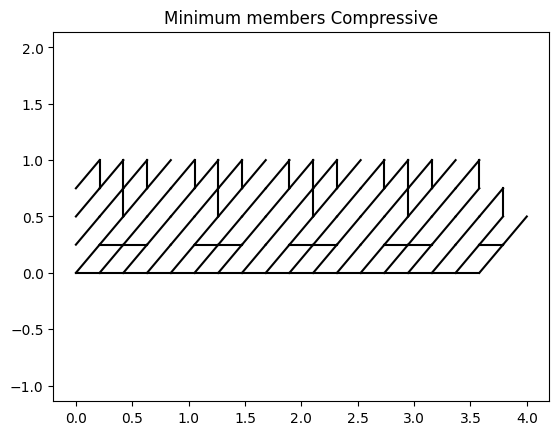

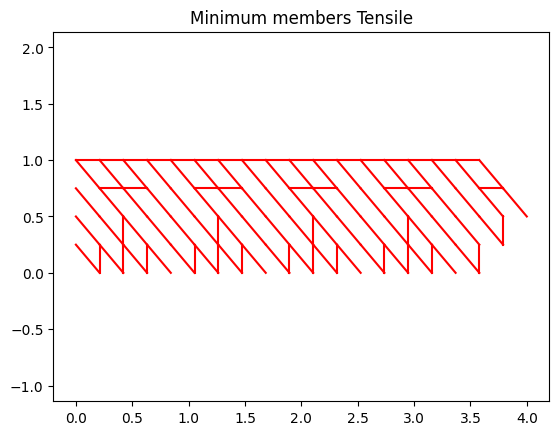

In [19]:
F_ext[1][np.where(np.nonzero(C_B_final))[0]] += -1
F_ext[1][np.where(np.nonzero(C_S_final))[0]] += -1
Cost = cp.norm(sigma_B,1) + cp.norm(sigma_S,1)
Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
              R[:,free_nodes[0]] == 0,
              sigma_B >= 0,
              sigma_S >= 0]
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.ECOS)
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[sigma_bar_member_indices]
C_S_final = C_S[sigma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Min Mass Solution')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Minimum members Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum members Tensile')
plt.show()

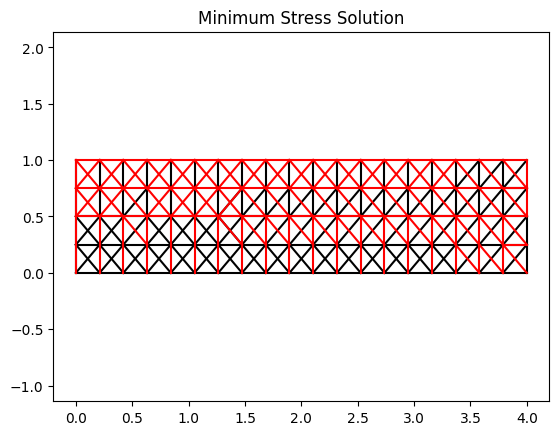

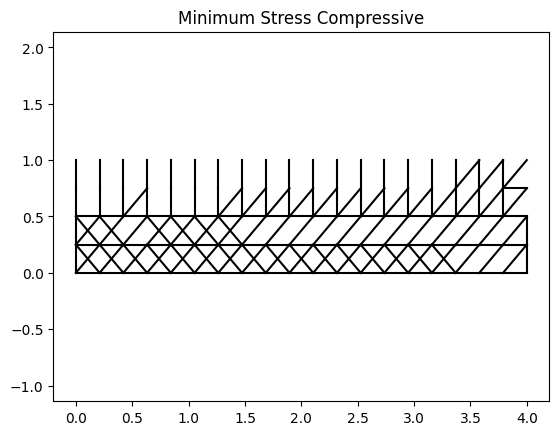

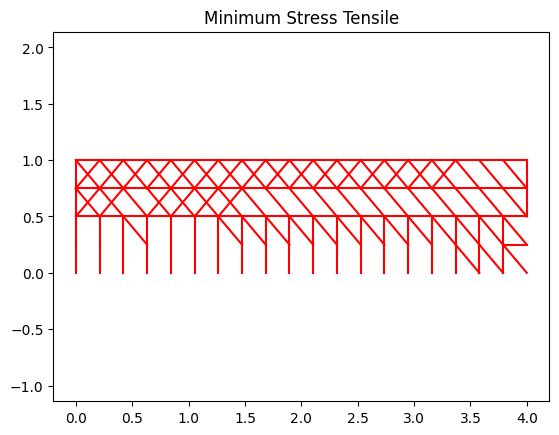

In [20]:
Cost = cp.norm(sigma_B,2) + cp.norm(sigma_S,2)
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.ECOS)
sigma_bar_member_indices = np.where(sigma_B.value >= 1*10**-3)[0]
sigma_cable_member_indices = np.where(sigma_S.value >= 1*10**-3)[0]
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[sigma_bar_member_indices]
C_S_final = C_S[sigma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum Stress Solution')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Minimum Stress Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum Stress Tensile')
plt.show()